# Load libraries and setup rejection sampling

In [ ]:
import numpy as np

np.random.seed(123456)

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

In [ ]:
import ipywidgets as wd

In [ ]:
import scipy.stats as sstats 
from scipy.stats import norm, beta 

In [ ]:
from scipy import optimize ### Use this for curve fitting

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler_1 = StandardScaler()

scaler_2 = StandardScaler()

scaler_3 = StandardScaler()

In [ ]:
from scipy.stats import gaussian_kde as GKDE

In [ ]:
def rejection_sampling(r):
    # Perform accept/reject sampling on a set of proposal samples using
    # the weights r associated with the set of samples and return
    # the indices idx of the proposal sample set that are accepted.
    N = r.size # size of proposal sample set
    check = np.random.uniform(low=0,high=1,size=N) # create random uniform weights to check r against
    M = np.max(r)
    new_r = r/M # normalize weights 
    idx = np.where(new_r>=check)[0] # rejection criterion
    return idx

# Time Series: Problems and Approaches

## Data and distributions on QoI

* A set of time series data typically represents a set of data for different quantities of interest (QoI) since each data point is defined by a different functional. 
<br>

    * A single datum is not enough to define/approximate a distribution for a QoI. But, if data are close enough in time there is a lot of correlation, so can we exploit that to construct distributions on a subset of QoI? 
   <br> <br>
    
    * We may take the perspective of a stochastic process and think of the data as coming from a statistical time series from a Markov process. From this perspective, we could try to turn the entire time series of data into a distribution on a single QoI. So, each datum represents the change in the Markov process and actually does come from a single distribution. 
<br>   

    
* ***The approaches discussed above both trade many values of data taken at many times for a statement of a distribution at a different time (or perhaps even for a QoI that is time invariant).***

## Fitting a time series model

* Alternatively, we may consider describing explicitly a stochastic time series model for the given data. 
From this perspective, we would try to find the best parameters for the time series model. 
This perspective is related to OED and determining frequency of data collection. 
<br><br>

* A time series model is likely only valid over certain time windows, and we need to define the window of time for which a model is valid, and this will subsequently define a different QoI. For example, over what time do you have a linear model? The collection of time windows defines different regimes for which different linear models are valid. This is related to data assimilation and EKF.

## Determining time windows for an ODE model

* How to determine time windows/regions over which time series models are valid? Investigate. This is a modeling question.

## Things to investigate and some references

Investigate the following:

* ROM for time dependent systems and the use of spectral decompositions. 

* Autoregressive models for time series data (https://en.wikipedia.org/wiki/Autoregressive_model)

* Connections to particle filtering and other types of data assimilation? https://en.wikipedia.org/wiki/Particle_filter

Some possibly useful references:

* http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016

* https://campus.datacamp.com/courses/introduction-to-time-series-analysis-in-python/correlation-and-autocorrelation?ex=1
    * https://campus.datacamp.com/courses/introduction-to-time-series-analysis-in-python/autoregressive-ar-models?ex=7


# Some initial examples -- Proof of concept

## An ODE model

Model is for harmonic motion
$$y''(t) + 2cy'(t) + \omega_0^2 x = f(t)$$
with damping constant
$$c \in [0.1,1]$$
and natural frequency
$$\omega_0\in[0.5,2]$$
and forcing term initially taken to be zero.

Note that with the ranges of $c$ and $\omega_0$ above, it is possible for the system to either be under-, over-, or critically damped (and since $c\geq 0.1$ it is never undamped, which is almost always physical nonsense). 

The roots to the characteristic equation are given by
$$ r_1 = -c\pm \sqrt{c^2-\omega_0^2}$$.

When the system is under-damped, the solution is given by
$$ y(t) = e^{-ct}[C_1\cos(\omega t) + C_2\sin(\omega t)], \ \omega=\sqrt{\omega_0^2-c^2}. $$


When the system is over-damped, the solution is given by 
$$ y(t) = C_1 e^{r_1t}+C_2 e^{r_2t}. $$

And, finally, when the system is critically damped, the solution is given by
$$ y(t) = C_1e^{-ct} + C_2 te^{-ct}. $$

However, we never expect the system to be critically damped in practice since this is "too fine-tuned" of a scenario. 

The constants $C_1$ and $C_2$ are determined by the initial conditions, which we assume to be given by
$$ y(0)=a, y'(0) = b $$
where 
$$ a\in[1,2] $$ 
and 
$$ b\in[-1,0] $$. 

In the under-damped case, 
$$ C_1 = a, \ \text{and } \ C_2 = \frac{b+ca}{\omega}. $$

In the over-damped case, 
$$ C_1 = \frac{b-ar_2}{r_1-r_2}, \ \text{and } \ C_2 = \frac{b-r_1a}{r_2-r_1} $$

A ***true*** distribution of $c, \omega_0, a$, and $b$ are defined by (non-uniform) Beta distributions and used to generate a set of time series data.

An ***initial*** uniform distribution is assumed and updated by the true time series data.

### Time series data appended with differences and sums

We initially assume no errors in the time series data, i.e., the observations are $y(t)$ at some finite set of times $\{t_i\}_{i=1}^N$, with $0\leq t_1 < t_2 < \cdots < t_N$. 

We also take differences and summations of the time series (to extract derivative and integral type information) and append to the data to determine if new/dominant features (i.e., principal components) are found. 

In [ ]:
def y(t, c, omega_0, a, b):
    z = np.zeros(len(c))
    ind_under = np.where(np.greater(omega_0, c))[0]
    ind_over = np.where(np.greater(c, omega_0))[0]
    # First solve for the under-damped case
    if ind_under.size > 0:
        omega = np.sqrt(omega_0[ind_under]**2 - c[ind_under]**2)
        C_1 = a[ind_under]
        C_2 = (b[ind_under]+c[ind_under]*a[ind_under])/omega
        
        z[ind_under] = np.exp(-c[ind_under]*t) * (C_1*np.cos(omega*t)
                                                  + C_2*np.sin(omega*t))
        
    if ind_over.size > 0:
        r_1 = -c[ind_over] - np.sqrt(c[ind_over]**2 - omega_0[ind_over]**2)
        r_2 = -c[ind_over] + np.sqrt(c[ind_over]**2 - omega_0[ind_over]**2)
        C_1 = (b[ind_over]-a[ind_over]*r_2)/(r_1-r_2)
        C_2 = (b[ind_over]-r_1*a[ind_over])/(r_2-r_1)
        
        z[ind_over] = C_1*np.exp(r_1*t) + C_2*np.exp(r_2*t)
        
    return z

#### Generate a test/prediction/prior set of parameters and observed data

In [ ]:
# Uniformly sample the parameter samples to form a "prediction" or "test" set

num_samples = int(1E3)

lam = np.random.uniform(size=(num_samples,4))

lam[:,0] = 0.1 + 0.4*lam[:,0]  #c
lam[:,1] = 0.5 + 1.5*lam[:,1] #omega_0
lam[:,2] = 1 + 1*lam[:,2] #a
lam[:,3] = -1 + 1*lam[:,3]   #b

In [ ]:
# Construct the predicted time series data

num_time_obs = int(50) #number of observations (uniformly space) between [time_start,time_end]
time_start = 0.5
time_end = 3.5
times = np.linspace(time_start, time_end, num_time_obs)

Q_samples_TS = np.zeros((num_samples,num_time_obs))

for i in range(num_time_obs):
    Q_samples_TS[:,i] = y(times[i],lam[:,0],lam[:,1],lam[:,2],lam[:,3])

#### Generate an observed set of data from a different distribution on parameters

The idea here is to show that we can reconstruct/recover a "true" distribution on parameters from observations. 
This establishes that we are indeed ***inverting*** a distribution on outputs.

However, in practice, we may only observe a ***single*** time series of data, polluted by noise, and impose a distribution on this time series data to invert.

Below, we simulate a peaked Beta distribution on a subset of the whole parameter space.

In [ ]:
# Simulate an observed distribution of time series data

num_obs_samples = int(1E3)

true_a = 2
true_b = 2

lam_obs = np.random.beta(size=(num_obs_samples,4),a=true_a,b=true_b)

lam_obs[:,0] = 0.1 + 0.4*lam_obs[:,0]  #c
lam_obs[:,1] = 0.5 + 1.5*lam_obs[:,1]  #omega_0
lam_obs[:,2] = 1 + 1*lam_obs[:,2]   #a
lam_obs[:,3] = -1 + 1*lam_obs[:,3]   #b

In [ ]:
Q_obs_samples_TS = np.zeros((num_obs_samples,num_time_obs))

with_noise = False
noise_stdev = 0.05

if with_noise:
    for i in range(num_time_obs):
        Q_obs_samples_TS[:,i] = y(times[i],lam_obs[:,0],lam_obs[:,1],lam_obs[:,2],lam_obs[:,3]) +\
                                 noise_stdev*np.random.randn(num_obs_samples)
else:
    for i in range(num_time_obs):
        Q_obs_samples_TS[:,i] = y(times[i],lam_obs[:,0],lam_obs[:,1],lam_obs[:,2],lam_obs[:,3])

#### Plot the predicted time series data in blue and the observed data in red

In [ ]:
plt.figure(figsize=(10,5))

for i in range(0,num_samples,20):
    plt.plot(times,Q_samples_TS[i,0:num_time_obs],'bo')
    
for i in range(0,num_obs_samples,10):
    plt.plot(times,Q_obs_samples_TS[i,0:num_time_obs],'r*')

### Determining some QoI through L2 style projection to splines with N knots followed by PCA

In [ ]:
from loq import *
learn = LoQ(Q_samples_TS, Q_obs_samples_TS, times, times)
learn.clean_data(time_start=0.5, time_end=3.5, num_time_obs=50, rel_tol=1.0e-3, min_knots=5, max_knots=10)

In [ ]:
# N = 7

# knots_init = np.linspace(times[0],times[-1], N)[1:-1]

# q_predict_pl = np.zeros((num_samples,2*N-2))

# for i in range(num_samples):
#     q_predict_pl[i,:], _ = optimize.curve_fit(lambda x, *params_0: wrapper_fit_func(x, N, params_0), 
#                                               times, Q_samples_TS[i,:], 
#                                               p0=np.hstack([np.zeros(N),knots_init]))

In [ ]:
plt.figure(figsize=(10,5))

for i in range(0,num_samples,200):
    plt.plot(learn.surrogate_times,learn.surrogate_predictions[i,:])
    plt.plot(times,Q_samples_TS[i,0:num_time_obs],'bo')
    #plt.plot(times, piecewise_linear(times, q_predict_pl[i,N:2*N], q_predict_pl[i,0:N]))

In [16]:
# print(q_predict_pl[0,:])
# print(q_predict_pl[0,N:])

In [17]:
# i = 3
# plt.plot(times,Q_samples_TS[i,0:num_time_obs],'bo')
# plt.plot(times, piecewise_linear(times, q_predict_pl[i,N:], q_predict_pl[i,0:N]))

In [18]:
# num_surrogate_time_obs = num_time_obs

# surrogate_times = np.linspace(time_start, time_end, num_surrogate_time_obs)

# surrogate_predictions = np.zeros((num_samples,num_surrogate_time_obs))
# for i in range(num_samples):
#     surrogate_predictions[i,:] = piecewise_linear(surrogate_times, 
#                                              q_predict_pl[i,N:2*N], 
#                                              q_predict_pl[i,0:N])

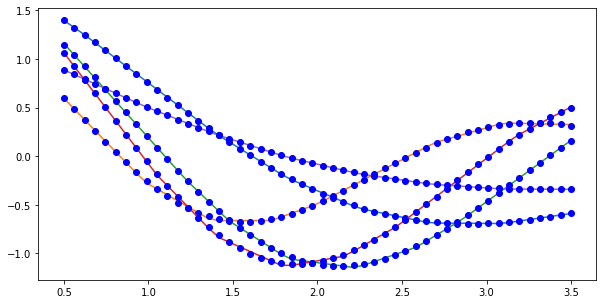

In [19]:
# i = 3
# plt.plot(times,Q_samples_TS[i,0:num_time_obs],'bo')
# plt.plot(times, piecewise_linear(times, q_predict_pl[i,N:], q_predict_pl[i,0:N]))
# plt.plot(surrogate_times, surrogate_predictions[i,:],'rs')
plt.figure(figsize=(10,5))

for i in range(0,num_samples,200):
    plt.plot(learn.surrogate_times,learn.surrogate_obs[i,:])
    plt.plot(times,Q_obs_samples_TS[i,0:num_time_obs],'bo')

In [20]:
kwargs = [{'n_clusters': 3,
           'n_init': 10},
          {'n_clusters': 3,
           'assign_labels': 'discretize',
           'random_state': 0}]

learn.learn_dynamics(cluster_methods=['kmeans', 'spectral'], kwargs=kwargs)

learn.classify_dynamics(kernel="rbf")

learn.learn_qoi(kernel='linear')

# from sklearn.cluster import SpectralClustering
# from sklearn.cluster import KMeans

# kmeans = False

# k_means = KMeans(init='k-means++', n_clusters=3, n_init=10)
# k_means.fit(surrogate_predictions)

# predict_labels_kmeans = k_means.labels_

# from sklearn import svm
# clustering = SpectralClustering(n_clusters=3,
#              assign_labels="discretize",
#              random_state=0).fit(surrogate_predictions)
# kernel = "rbf" # "rbf", "poly", "sigmoid", "linear"
# clf = svm.SVC(kernel=kernel, gamma='auto')
# clf.fit(surrogate_predictions, clustering.labels_)
# # clf.fit(surrogate_predictions, k_means.labels_)
# predict_labels_clustering = clf.predict(surrogate_predictions)
# #print(clf.score(surrogate_predictions, clustering.labels_))
# if kmeans:
#     predict_labels = predict_labels_kmeans
# else:
#     predict_labels = predict_labels_clustering

[KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
           fit_inverse_transform=False, gamma=None, kernel='linear',
           kernel_params=None, max_iter=None, n_components=None, n_jobs=None,
           random_state=None, remove_zero_eig=False, tol=0),
 KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
           fit_inverse_transform=False, gamma=None, kernel='linear',
           kernel_params=None, max_iter=None, n_components=None, n_jobs=None,
           random_state=None, remove_zero_eig=False, tol=0),
 KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
           fit_inverse_transform=False, gamma=None, kernel='linear',
           kernel_params=None, max_iter=None, n_components=None, n_jobs=None,
           random_state=None, remove_zero_eig=False, tol=0)]

In [ ]:
# print(predict_labels_clustering)
# print(k_means.labels_)

In [ ]:
for i in range(num_samples):
    if predict_labels[i]==2:
        plt.plot(surrogate_times, surrogate_predictions[i,:])

# time_idx = np.where(clustering.labels_==0)[0]
# for i in range(num_samples):   
#     plt.plot(surrogate_times[time_idx], surrogate_predictions[i,time_idx])

In [ ]:
# from sklearn.decomposition import PCA, KernelPCA

# X_std_1 = scaler_1.fit_transform(surrogate_predictions[np.where(predict_labels==0)[0],:])

# X_std_2 = scaler_2.fit_transform(surrogate_predictions[np.where(predict_labels==1)[0],:])

# X_std_3 = scaler_3.fit_transform(surrogate_predictions[np.where(predict_labels==2)[0],:])                             

# kernel = "linear" #"rbf" # "linear", "poly", "sigmoid", "cosine"

# kpca1 = KernelPCA(kernel=kernel, fit_inverse_transform=False)
# kpca2 = KernelPCA(kernel=kernel, fit_inverse_transform=False)
# kpca3 = KernelPCA(kernel=kernel, fit_inverse_transform=False)

# X_kpca1 = kpca1.fit_transform(X_std_1)
# X_kpca2 = kpca2.fit_transform(X_std_2)
# X_kpca3 = kpca3.fit_transform(X_std_3)


# eig_vals_1 = kpca1.lambdas_
# eig_vals_2 = kpca2.lambdas_
# eig_vals_3 = kpca3.lambdas_


In [ ]:
%reset -f out

def plot_gap(eig_vals, n):
    fig = plt.figure(figsize=(10,10))
    fig.clear()
    plt.semilogy(np.arange(np.size(eig_vals)),eig_vals, Marker='*', linestyle='')
    plt.semilogy(np.arange(np.size(eig_vals)),eig_vals[n]*np.ones(np.size(eig_vals)), 'r--')
    plt.semilogy(np.arange(np.size(eig_vals)),eig_vals[n+1]*np.ones(np.size(eig_vals)), 'r--')
    s = 'Orders of magnitude between %d and %d e.vals is %4.2f' %(n, n+1, 
                                                                  np.log10(eig_vals[n])-np.log10(eig_vals[n+1]))
    s += '\n and e.vals up to %d account for %4.2f percent of variation' %(n, 
                                                                           np.sum(eig_vals[0:n+1])/np.sum(eig_vals)*100)
    plt.title(s)

wd.interact(plot_gap,
            eig_vals = wd.fixed(eig_vals_2),
            n = wd.IntSlider(value=0, min=0, max=20))

In [ ]:
# %reset -f out

# def plot_eigvecs(eig_vals, eig_vecs, n):
#     fig = plt.figure(figsize=(10,10))
#     fig.clear()
#     plt.plot(np.arange(np.size(eig_vals)),eig_vecs[:,n], Marker='*', linestyle='', color='k')
#     plt.title('Eigenvector ' + str(n))
#     plt.ylim([-1,1])

# wd.interact(plot_eigvecs, 
#             eig_vals = wd.fixed(eig_vals_1),
#             eig_vecs = wd.fixed(eig_vecs_1),
#             n = wd.IntSlider(value=0,min=0,max=10))

In [ ]:
#Clear figure each time this is run to save memory
%reset -f out

#define all the potential QoI
q_predict_PCA_1 = X_kpca1 #np.dot(X_std_1, eig_vecs_1)
q_predict_PCA_2 = X_kpca2#np.dot(X_std_2, eig_vecs_2)
q_predict_PCA_3 = X_kpca3 #np.dot(X_std_3, eig_vecs_3)

#create a plot function to check out any pairs of QoI desired
def plot_QoI_pairs(q_predict, q1, q2):
    fig = plt.figure(figsize=(10,10))
    fig.clear()
    plt.scatter(q_predict[:,q1],q_predict[:,q2])
    plt.title('Visualizing the skewness/correlation between QoI ' + str(q1) + ' and ' + str(q2))

#allow interactivity of plotting
wd.interact(plot_QoI_pairs, 
            q_predict = wd.fixed(q_predict_PCA_1), 
            q1 = wd.IntSlider(value=0,min=0,max=q_predict_PCA_1[0,:].size-1,step=1), 
            q2 = wd.IntSlider(value=1,min=0,max=q_predict_PCA_1[0,:].size-1,step=1),
            continuous_update=False)

### Now choose how many QoI to use from the principal components and construct a predicted density either using a standard Gaussian KDE 

***Still to-do:*** Try just using machine learning to determine an optimal KDE with a chosen kernel that allows for compact support and uses cross-validation to optimize bandwidth. Need to investigate further. Code below is commented out because it takes too long to run.

In [ ]:
QoI_list = range(4)
QoI_num = len(QoI_list)

q_predict_maps = [q_predict_PCA_1[:,QoI_list], q_predict_PCA_2[:,QoI_list], q_predict_PCA_3[:,QoI_list]]

pi_Q_kdes = [GKDE( q_predict_maps[0].T ), GKDE( q_predict_maps[1].T ), GKDE( q_predict_maps[2].T )]

### Now transform the observations.

In [ ]:
q_obs_pl = np.zeros((num_obs_samples,2*N-2))

p0_init = np.hstack([np.zeros(N), knots_init])
p0_init[0] = 1

for i in range(num_obs_samples):
    q_obs_pl[i,:], _ = optimize.curve_fit(lambda x, *params_0: wrapper_fit_func(x, N, params_0), 
                                          times, Q_obs_samples_TS[i,:], 
                                          p0=p0_init)

In [ ]:
surrogate_obs = np.zeros((num_obs_samples,num_surrogate_time_obs))
for i in range(num_samples):
    surrogate_obs[i,:] = piecewise_linear(surrogate_times, 
                                          q_obs_pl[i,N:2*N], 
                                          q_obs_pl[i,0:N])

In [ ]:
# obs_labels = k_means.predict(surrogate_obs)
if kmeans:
    obs_labels = k_means.predict(surrogate_obs)
else:
    obs_labels = clf.predict(surrogate_obs) #clustering.transform(surrogate_obs)
print(obs_labels)

In [ ]:
plt.figure()

cluster_num = 0
for i in range(num_samples):
    if predict_labels[i]==cluster_num:
        plt.plot(surrogate_times, surrogate_predictions[i,:],'b*')

for i in range(num_obs_samples): 
    if obs_labels[i]==cluster_num:
        plt.plot(surrogate_times, surrogate_obs[i,:],'r')

In [ ]:
X_test_1 = scaler_1.transform(surrogate_obs[np.where(obs_labels==0)[0],:])

X_test_2 = scaler_2.transform(surrogate_obs[np.where(obs_labels==1)[0],:])

X_test_3 = scaler_3.transform(surrogate_obs[np.where(obs_labels==2)[0],:])                             

q_obs_PCA_1 = kpca1.transform(X_test_1)#np.dot(X_test_1, eig_vecs_1)

q_obs_PCA_2 = kpca2.transform(X_test_2)#np.dot(X_test_2, eig_vecs_2)

q_obs_PCA_3 = kpca3.transform(X_test_3)#np.dot(X_test_3, eig_vecs_3)

In [ ]:
# Visually inspect results
#Clear figure each time this is run to save memory
%reset -f out

#create a plot function to check out any pairs of QoI desired
def plot_QoI_pairs(q_predict, q_obs, q1, q2):
    fig = plt.figure(figsize=(10,10))
    fig.clear()
    plt.scatter(q_predict[:,q1],q_predict[:,q2])
    plt.scatter(q_obs[:,q1],q_obs[:,q2])

#allow interactivity of plotting
wd.interact(plot_QoI_pairs, 
            q_predict = wd.fixed(q_predict_PCA_2), 
            q_obs = wd.fixed(q_obs_PCA_2),
            q1 = wd.IntSlider(value=0,min=0,max=q_predict_PCA_2[0,:].size-1,step=1), 
            q2 = wd.IntSlider(value=1,min=0,max=q_predict_PCA_2[0,:].size-1,step=1),
            continuous_update=False)

#### Now extract the same number of QoI from the observed set and construct an observed density.

In [ ]:
q_obs_maps = [q_obs_PCA_1[:,QoI_list], q_obs_PCA_2[:,QoI_list], q_obs_PCA_3[:,QoI_list]]

pi_obs_kdes = [GKDE( q_obs_maps[0].T ), GKDE( q_obs_maps[1].T ), GKDE( q_obs_maps[2].T )]

### Now perform rejection sampling on predicted set to obtain an i.i.d. sample set from a distribution consistent with the observed (consistent in the sense that it comes from a pullback measure).

We printout the acceptance rate of samples as well as the mean value of the rejection ratio 

$$
    r(\lambda) = \frac{\pi_{\mathcal{D}}^{obs}(Q(\lambda))}{\pi_\mathcal{D}^{predict}(Q(\lambda))}, 
$$

which should be ***close*** to 1 to indicate that the updated density defined by

$$
    \pi_\Lambda^{update} = \pi_\Lambda^{predict}(\lambda)\frac{\pi_{\mathcal{D}}^{obs}(Q(\lambda))}{\pi_\mathcal{D}^{predict}(Q(\lambda))}
$$

is in fact a density. This form and result follows from the disintegration theorem. See [Combining Push-Forward Measures and Bayes' Rule to Construct Consistent Solutions to Stochastic Inverse Problems](https://epubs.siam.org/doi/abs/10.1137/16M1087229) for more details (note that I am using notation more consistent with the newer reference on this subject found [here](https://epubs.siam.org/doi/abs/10.1137/18M1181675) on convergence properties of this updated density using approximate QoI maps).

In [ ]:
num_clusters = 3

r = []
samples_to_keep = []
consistent_lam = []

for i in range(num_clusters):
#First compute the rejection ratio
    r.append(np.divide(pi_obs_kdes[i](q_predict_maps[i].T),pi_Q_kdes[i](q_predict_maps[i].T)))

    #Now perform rejection sampling and return the indices we keep
    samples_to_keep.append(rejection_sampling(r[i]))

    #Now print some diagnostics
    print(r[i].mean()) # Want this close to 1

In [ ]:
# # Visually inspect results
# #Clear figure each time this is run to save memory
# %reset -f out

# #create a plot function to check out any pairs of lambda desired
# def plot_lambda_pairs(lam1, lam2):
#     fig = plt.figure(figsize=(10,10))
#     fig.clear()
#     plt.scatter(lam[:,lam1],lam[:,lam2])
#     plt.scatter(lam_obs[:,lam1],lam_obs[:,lam2])
#     plt.scatter(consistent_lam[:,lam1],consistent_lam[:,lam2])

# #allow interactivity of plotting
# wd.interact(plot_lambda_pairs, 
#             lam1 = wd.IntSlider(value=0,min=0,max=3,step=1), 
#             lam2 = wd.IntSlider(value=1,min=0,max=3,step=1),
#             continuous_update=False)

### Estimate marginals of parameters using a weighted KDE fit. This requires `scipy` to be version 1.2.1.

In [ ]:
param_marginals = []
true_sample_marginals = []

lam_ptr = [np.where(predict_labels==0)[0],
           np.where(predict_labels==1)[0],
           np.where(predict_labels==2)[0]]

cluster_weights = [len(np.where(obs_labels==0)[0]) / num_obs_samples,
                   len(np.where(obs_labels==1)[0]) / num_obs_samples,
                   len(np.where(obs_labels==2)[0]) / num_obs_samples] 

for i in range(4):
    true_sample_marginals.append(GKDE(lam_obs[:,i]))
    param_marginals.append([])
    for j in range(num_clusters):
        param_marginals[i].append(GKDE(lam[lam_ptr[j],i], weights=r[j]))

In [ ]:
fig = plt.figure(figsize=(10,10))
fig.clear()
x = np.linspace(0.1,1,100)
plt.plot(x, 1/.9*np.ones(100), label = 'Initial guess')
plt.plot(x, param_marginals[0][0](x) * cluster_weights[0] 
           +param_marginals[0][1](x) * cluster_weights[1]
           +param_marginals[0][2](x) * cluster_weights[2], label = 'Estimated pullback')
plt.plot(x, true_sample_marginals[0](x), label = 'Actual density')
plt.title('Comparing pullback to actual density of parameter $c$', fontsize=16)
plt.legend(fontsize=20)

In [ ]:
fig = plt.figure(figsize=(10,10))
fig.clear()
x = np.linspace(0.5,2,100)
plt.plot(x, 1/1.5*np.ones(100), label = 'Initial guess')
plt.plot(x, param_marginals[1][0](x) * cluster_weights[0] 
           +param_marginals[1][1](x) * cluster_weights[1]
           +param_marginals[1][2](x) * cluster_weights[2], label = 'Estimated pullback')
plt.plot(x, true_sample_marginals[1](x), label = 'Actual density')
plt.title('Comparing pullback to actual density of parameter $\omega_0$', fontsize=16)
plt.legend(fontsize=20)

In [ ]:
fig = plt.figure(figsize=(10,10))
fig.clear()
x = np.linspace(1,2,100)
plt.plot(x, 1*np.ones(100), label = 'Initial guess')
plt.plot(x, param_marginals[2][0](x) * cluster_weights[0] 
           +param_marginals[2][1](x) * cluster_weights[1]
           +param_marginals[2][2](x) * cluster_weights[2], label = 'Estimated pullback')
plt.plot(x, true_sample_marginals[2](x), label = 'Actual density')
plt.title('Comparing pullback to actual density of parameter $a$', fontsize=16)
plt.legend(fontsize=20)

In [ ]:
fig = plt.figure(figsize=(10,10))
fig.clear()
x = np.linspace(-1,0,100)
plt.plot(x, 1*np.ones(100), label = 'Initial guess')
plt.plot(x, param_marginals[3][0](x) * cluster_weights[0] 
           +param_marginals[3][1](x) * cluster_weights[1]
           +param_marginals[3][2](x) * cluster_weights[2], label = 'Estimated pullback')
plt.plot(x, true_sample_marginals[3](x), label = 'Actual density')
plt.title('Comparing pullback to actual density of parameter $b$', fontsize=16)
plt.legend(fontsize=20)

In [ ]:
fig = plt.figure(figsize=(10,10))
fig.clear()

plt.scatter(lam[lam_ptr[0],3],q_predict_PCA_1[:,2])

## Workflow of BET + LoQ

BET.solve_TS_data(predicted_time_series_array, observed_time_series_array)

### User does not see the following calls

LoQ.clean_data()

LoQ.learn_dynamics <--- labeling

LoQ.classify_dynamics <--- svm

LoQ.learn_QoI <---- kPCA

LoQ.classify_observations <---- svm to label observations
LoQ.transform_observations <--- kPCA on labeled oversations

LoQ.create_sample_objects <---- output sample objects for predicted and observed QoI

## For non-time series (i.e., for spatial) data

BET.solve_spatial_data(spatial_data_array, observed_time_series_array)

No call to LoQ.clean_data()